In [48]:
import os
import time
import json

import numpy as np
import skimage
import tifffile 

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

from dice import dice_coef, dice_loss
from predict import predict_mask

from generator import DataGen
from visualize import display_slice_from_batch
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, precision_score, recall_score



In [31]:
test_path = "/Users/dnadeem/Desktop/dl/pyLattice_deepLearning/src/quickstart-gendata/test/Region168/lattice_light_sheet.tif"
truth_path = "/Users/dnadeem/Desktop/dl/pyLattice_deepLearning/src/quickstart-gendata/test/Region168/truth.tif"
model_path = "jan30_largeframe_32_nonzero_standardized_local.keras"

#test_ids = next(os.walk(test_path))[1] # Returns all directories under train_path
batch_size = 2
patch_size = 32 
percent_covered = 1e-10

In [11]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = load_model(model_path, custom_objects={'dice': dice_loss(), 'dice_coef': dice_coef})

2024-06-08 22:13:42.995279: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-08 22:13:42.995337: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-06-08 22:13:42.995348: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-06-08 22:13:42.995391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-08 22:13:42.995417: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
test_image = tifffile.imread(test_path)

# Add a batch dimension at the beginning and a channel dimension at the end
input_array = np.expand_dims(test_image, axis=0)  # Now shape is (1, 32, 32, 32)
input_array = np.expand_dims(input_array, axis=-1)  # Now shape is (1, 32, 32, 32, 1)

prediction = model.predict(input_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


In [33]:
truth_image = tifffile.imread(truth_path)

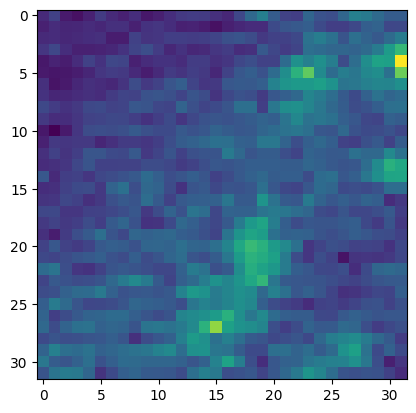

In [40]:
plt.imshow(test_image[1,:,:])

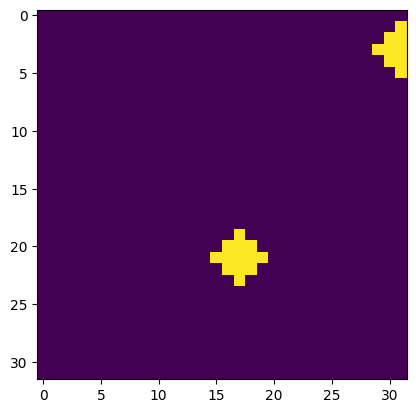

In [41]:
plt.imshow(truth_image[1,:,:])

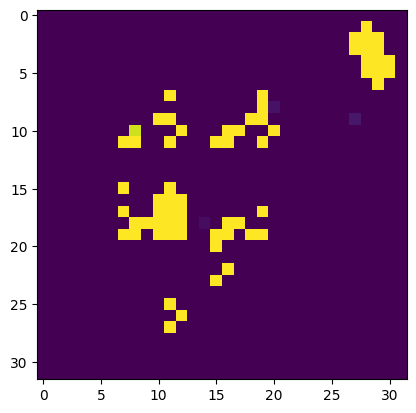

In [42]:
plt.imshow(prediction[0,1,:,:,0])

In [7]:
x, y = gen.__getitem__(0)
print(x.shape)

(2, 32, 32, 32, 1)


In [52]:
def load_and_prepare_data(folder_path):
    images = []
    masks = []
    
    # Traverse through all subfolders
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            image_path = os.path.join(subfolder_path, 'lattice_light_sheet.tif')
            mask_path = os.path.join(subfolder_path, 'truth.tif')
            
            # Load and resize image and mask
            image = imread(image_path)
            mask = imread(mask_path)
            image = resize(image, (32, 32, 32), preserve_range=True, anti_aliasing=True)
            mask = resize(mask, (32, 32, 32), preserve_range=True, anti_aliasing=True)
            
            # Reshape for the model
            image = np.expand_dims(image, axis=0)  # Add batch dimension
            image = np.expand_dims(image, axis=-1)  # Add channel dimension
            
            images.append(image)
            masks.append(mask)
    
    return np.vstack(images), np.stack(masks)


In [57]:
images, mask = load_and_prepare_data(folder_path = '/Users/dnadeem/Desktop/dl/pyLattice_deepLearning/src/quickstart-gendata/test')

In [72]:
def evaluate_model(test_folder, model):
    test_images, test_masks = load_and_prepare_data(test_folder)
    print(test_images.shape)
    predictions = model.predict(test_images)
    predictions = predictions > 0.5  # Threshold predictions

    # Flatten arrays for evaluation
    true_masks = test_masks.flatten()
    predicted_masks = predictions.flatten()

    accuracy = accuracy_score(true_masks, predicted_masks)
    #precision = precision_score(true_masks, predicted_masks)
    #recall = recall_score(true_masks, predicted_masks)

    print(f"Accuracy: {accuracy}")
    #print(f"Precision: {precision}")
    #print(f"Recall: {recall}")
    
    # Optionally visualize some predictions
    # fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # axes[0].imshow(test_images[0,0,:,:,0], cmap='gray')  # Display first image
    # axes[1].imshow(test_masks[0], cmap='gray')  # Display its mask
    # axes[2].imshow(predictions[0,0,:,:,0], cmap='gray')  # Display predicted mask
    # plt.show()
    return predictions, test_masks, test_images


In [73]:
# Call the function
predictions, test_masks, test_images = evaluate_model(test_folder = '/Users/dnadeem/Desktop/dl/pyLattice_deepLearning/src/quickstart-gendata/test', model = model)

(42, 32, 32, 32, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Accuracy: 0.9802180698939732


In [74]:
print(predictions.shape)
print(test_masks.shape)

(42, 32, 32, 32, 1)
(42, 32, 32, 32)


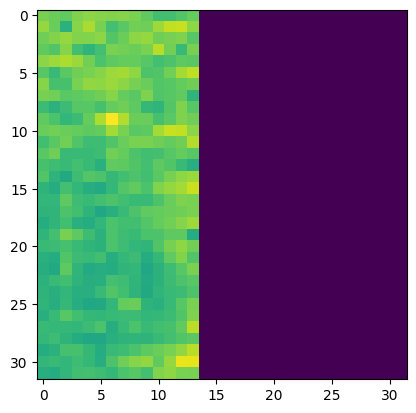

In [124]:
plt.imshow(test_images[0,25,:,:,0])  # Display first image

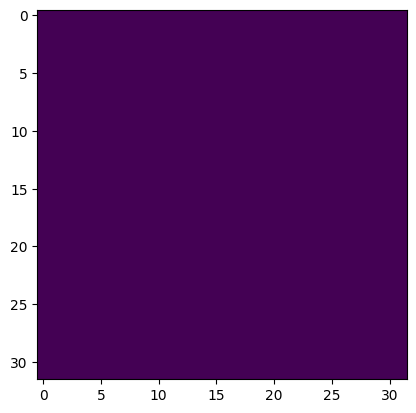

In [125]:
plt.imshow(test_masks[0,25,:,:])  # Display its mask

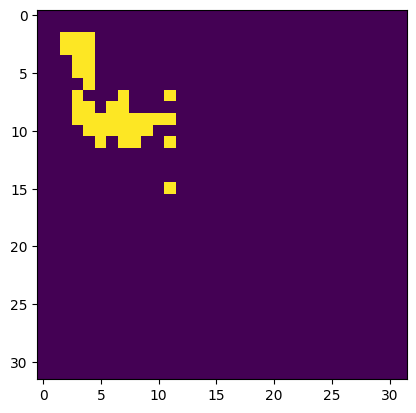

In [126]:
plt.imshow(predictions[0,25,:,:,0])  # Display predicted mask